In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

% matplotlib inline

data = pd.read_csv("data/train_clean.csv")
data.head()

,longitude,latitude,lithology,bathymetry,nitrate,oxygen,phosphate,productivity,salinity,silicate,temperature
0,-180,75,4,-231.0,NaN,8.552258,NaN,310.199677,31.165499,NaN,-0.878415
1,-179,75,4,-203.0,1.702168,9.494461,0.754516,312.468658,29.931450,12.485500,-1.785413
2,-178,75,4,-304.0,1.850258,9.578869,0.735949,291.436279,30.048571,12.902109,-1.904204
3,-177,75,4,-278.0,1.960688,9.668440,0.720070,277.305817,30.211161,13.251008,-1.869162
4,-176,75,4,-247.0,2.056301,9.763065,0.706926,262.947571,30.398439,13.591722,-1.688048


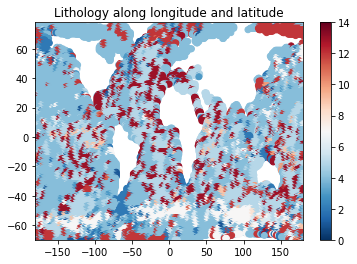

In [2]:
lon = data["longitude"].values
lat = data["latitude"].values
y = data["lithology"].values


# plot lithology vesus longitude and latitude
def draw_global(lon, lat, y, title, cmap="RdBu_r", vmin=0, vmax=14):
    sc = plt.scatter(lon, lat, c=y, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlim([-180, 180])
    plt.ylim([-70, 78])
    plt.colorbar(sc)
    plt.show()

draw_global(lon, lat, y, "Lithology along longitude and latitude")

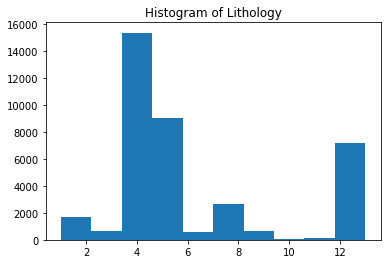

Unique class = [ 1  2  3  4  5  6  7  8  9 10 11 12 13]


In [3]:
# plot the histogram of lithology
plt.hist(y)
plt.title("Histogram of Lithology")
plt.show()
print("Unique class = {}".format(np.unique(y)))

### One-vs-all

Build 13 classifier such that

$$h_\theta^{(i)}(x) = P(y=i|x; \theta) \quad (i=1, 2, ..., 13)$$

Train a logistic regression classifier $h_\theta^{(i)}(x)$ for each class $i$ to predict the probability that $y=i$.

On a new input $x$, to make a prediction, pick the class i that maximizes
$$max_{i} h_\theta^{(i)}(x)$$

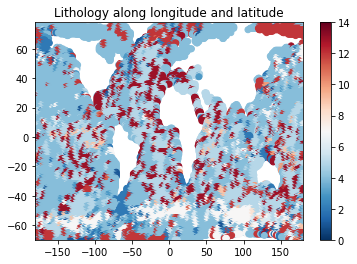

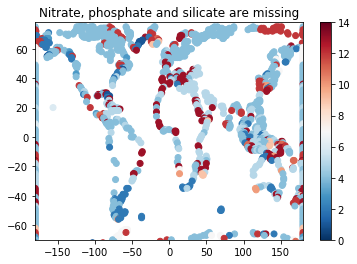

In [4]:
# training data should exclude longitude and latitude
training_data = data.copy()
del training_data["longitude"]
del training_data["latitude"]
training_data.head()

# feature missing reports
# for col in training_data:
#     missing = sum(pd.isnull(training_data[col]))
#     print("Missing Count in {} = {}".format(col, missing))
    

# check missing are consistent
nitrate_missing = pd.isnull(training_data["nitrate"])
phosphate_missing = pd.isnull(training_data["phosphate"])
silicate_missing = pd.isnull(training_data["silicate"])
assert np.array_equal(nitrate_missing, phosphate_missing)
assert np.array_equal(nitrate_missing, silicate_missing)


# global map including and excluding missing parts
draw_global(lon, lat, y, "Lithology along longitude and latitude")
# highlight place of missing
draw_global(lon[nitrate_missing],
            lat[nitrate_missing],
            y[nitrate_missing], 
            "Nitrate, phosphate and silicate are missing")

In [5]:
# obtain list of feature names
target = "lithology"
features = list(training_data.columns)
features.remove(target)

# impute missing with mean
fill_dict = {}
for col in training_data:
    fill_dict[col] = np.mean(training_data[col])
training_data = training_data.fillna(value=fill_dict)

# construct X and y 
X = training_data[features].as_matrix()
y = training_data[target].as_matrix()

In [6]:
# import sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

# import sklearn preprocessing and validation
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, Imputer

def validate(X, y, classifier, name):
    """Validate with given classifier."""
    # standardize X
    X = StandardScaler().fit_transform(X)
    # cross validation and obtain prediction
    prediction = cross_val_predict(classifier, X, y, cv=3)
    acc = round(accuracy_score(y, prediction), 4)
    title = "Prediction Model={} ACC={}".format(name, acc)
    draw_global(lon, lat, prediction, title)

# different classifiers
logistic = LogisticRegression()
rfc = RandomForestClassifier()
gpc = GaussianProcessClassifier()

# cross validation
draw_global(lon, lat, y, "Actual Lithology")
validate(X, y, logistic, "LogisticRegression")
validate(X, y, rfc, "RandomForestClassifier")

In [7]:
def batch_training(X, Y, M, batch_size, n_epochs):
    """Batch training queue convenience function."""
    data_tr = tf.data.Dataset.from_tensor_slices({'X': X, 'Y': Y, 'M': M}) \
        .shuffle(buffer_size=1000, seed=RSEED) \
        .repeat(n_epochs) \
        .batch(batch_size)
    data = data_tr.make_one_shot_iterator().get_next()
    return data['X'], data['Y'], data['M']


In [8]:
import logging
import tensorflow as tf
import aboleth as ab
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Make missing data?
USE_ABOLETH = True  # Use Aboleth to learn an imputation?

RSEED = 0
ab.set_hyperseed(RSEED)

FRAC_TEST = 0.1  # Fraction of data to use for hold-out testing

# Optimization
NEPOCHS = 5  # Number of times to see the data in training
BSIZE = 100  # Mini batch size
CONFIG = tf.ConfigProto(device_count={'GPU': 0})  # Use GPU ?
LSAMPLES = 5  # Number of samples the mode returns
PSAMPLES = 50  # Number of predictions samples

NCLASSES = 13  # Number of target classes
NFEATURES = 8  # Number of random features to use

# data set
X = training_data[features].as_matrix().astype(np.float32)
Y = (training_data[target].as_matrix() - 1).astype(np.float32)

# Network construction
n_samples_ = tf.placeholder_with_default(LSAMPLES, [])
data_input = ab.InputLayer(name='X', n_samples=n_samples_)  # Data input

rnd = np.random.RandomState(RSEED)
scale = rnd.rand(8)
scale = scale[:, None]
lenscale = ab.pos(tf.Variable(scale, dtype=np.float32))

layers = (
    ab.RandomArcCosine(n_features=NFEATURES, lenscale=lenscale) >>
    ab.RandomArcCosine(n_features=NFEATURES, lenscale=lenscale) >>
    ab.DenseVariational(output_dim=NCLASSES)
)

X = StandardScaler().fit_transform(X)
net = data_input >> layers

# Split the training and testing data
ind_tr, ind_ts = train_test_split(
    range(len(X)),
    test_size=FRAC_TEST,
    random_state=RSEED)

X_tr, X_ts = X[ind_tr], X[ind_ts]
Y_tr, Y_ts = Y[ind_tr], Y[ind_ts]
M = np.zeros(X.shape, dtype=bool)
M_tr, M_ts = M[ind_tr], M[ind_ts]
N_tr, D = X_tr.shape

# Data
with tf.name_scope("Input"):
    Xb, Yb, _ = batch_training(X_tr, Y_tr, M_tr, n_epochs=NEPOCHS,
                                batch_size=BSIZE)
    X_ = tf.placeholder_with_default(Xb, shape=(None, D))
    # Y_ has to be this dimension for compatability with Categorical
    Y_ = tf.placeholder_with_default(Yb, shape=(None,))

with tf.name_scope("Deepnet"):
    # Conditionally assign a placeholder for masks if USE_ABOLETH
    nn, kl = net(X=X_)
    lkhood = tf.distributions.Categorical(logits=nn)
    loss = ab.elbo(lkhood, Y_, N_tr, kl)
    prob = ab.sample_mean(lkhood.probs)

with tf.name_scope("Train"):
    optimizer = tf.train.AdamOptimizer()
    global_step = tf.train.create_global_step()
    train = optimizer.minimize(loss, global_step=global_step)

# Logging learning progress
log = tf.train.LoggingTensorHook(
    {'step': global_step, 'loss': loss},
    every_n_iter=1000
)

# This is the main training "loop"
with tf.train.MonitoredTrainingSession(
        config=CONFIG,
        save_summaries_steps=None,
        save_checkpoint_secs=None,
        hooks=[log]
) as sess:
    try:
        while not sess.should_stop():
            sess.run(train)
    except tf.errors.OutOfRangeError:
        print('Input queues have been exhausted!')
        pass

    # Prediction
    feed_dict = {X_: X_ts, Y_: [0], n_samples_: PSAMPLES}
    p = sess.run(prob, feed_dict=feed_dict)

# Get mean of samples for prediction, and max probability assignments
Ey = p.argmax(axis=1)

# Score results
acc = accuracy_score(Y_ts, Ey)
ll = log_loss(Y_ts, p)
conf = confusion_matrix(Y_ts, Ey)
print("Final scores:")
print("\tAccuracy = {}\n\tLog loss = {}\n\tConfusion =\n{}".
      format(acc, ll, conf))


/home/joyce/.virtualenvs/sea/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


INFO:tensorflow:step = 1, loss = 460944.0
INFO:tensorflow:step = 1001, loss = 192676.0 (2.428 sec)
Input queues have been exhausted!
Final scores:
	Accuracy = 0.3009198423127464
	Log loss = 1.917935479078907
	Confusion =
[[  0   0   0  21   6   0   0   0   0   0   0   0   1]
 [  0   6   0  95  20   0   0   0   0   0   0   5   5]
 [  0   0   0  29  22   0   0   0   0   0   0   1   5]
 [  0  35   2 430 996   4   0   0   0   0   0  26  41]
 [  0  10   0 199 672   1   0   0   0   0   0   1  37]
 [  0   0   0  28  32   2   0   0   0   0   0   0   1]
 [  0   1   0 183  58   1   0   0   0   0   0   1  16]
 [  0   0   0   3   3   0   0   0   0   0   0   0   1]
 [  0   0   0  12  47   0   0   0   0   0   0   0   2]
 [  0   0   0   7   2   0   0   0   0   0   0   0   0]
 [  0   0   0  11   6   0   0   0   0   0   0   0   0]
 [  0   2   0 189  71   0   0   0   0   0   0   6  13]
 [  0   2   1  67 338   0   0   0   0   0   0   0  29]]


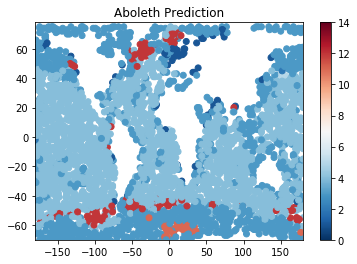

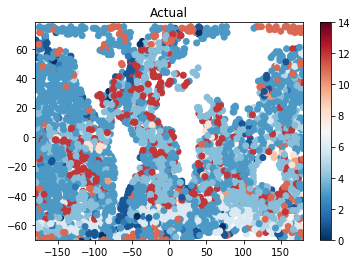

In [9]:
draw_global(lon[ind_ts], lat[ind_ts], Ey, "Aboleth Prediction")
draw_global(lon[ind_ts], lat[ind_ts], Y_ts, "Actual")